In [9]:
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_275000_3951000_image.tif"
from deepforest import main
from deepforest import get_data
from deepforest import utilities
import matplotlib.pyplot as plt
import rasterio
import rasterio.features
import rasterio.warp
import os
model = main.deepforest()
model.use_release()

Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [10]:


model = main.deepforest()
model.use_release()

sample_image = get_data(sample_image_path)

img = model.predict_tile(sample_image, return_plot = True, patch_size=500,patch_overlap=0.25)
plt.imsave(f"output3_patch_size=500_patch_overlap=0.25.png", img[:,:,::-1])

#predict_image returns plot in BlueGreenRed (opencv style), but matplotlib likes RedGreenBlue, switch the channel order. Many functions in deepforest will automatically perform this flip for you and give a warning.
# plt.imshow(img[:,:,::-1])
# plt.imsave(f"output2_patch_size=500_patch_overlap=0.1.png", img[:,:,::-1])

Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:14<00:00, 50.53it/s]
36432 predictions in overlapping windows, applying non-max supression
20919 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/visualize.py:126: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. "


In [3]:
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_267000_3942000_image.tif"

sample_image = get_data(sample_image_path)

predictions = model.predict_tile(sample_image, patch_size=500,patch_overlap=0.25)

with rasterio.open(sample_image_path) as df:
    transform = df.transform
    crs = df.crs
    gdf = utilities.annotations_to_shapefile(predictions, transform=transform, crs=crs)
    print(gdf.total_bounds)
    print(gdf.crs)
    # CRS.from_epsg(32617)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:14<00:00, 50.76it/s]
20346 predictions in overlapping windows, applying non-max supression
11628 predictions kept after non-max suppression
[ 267294.65 3941999.95  268000.05 3942999.95]
PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/utilities.py:476: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be "


In [48]:

output_dir = "bounding_box_images"
os.makedirs(output_dir, exist_ok=True)
# Sort the dataframe by score and filter to top 500
gdf = gdf.sort_values(by="score", ascending=False)
gdf = gdf.head(500)


# Open the original image
with rasterio.open(sample_image_path) as src:
    # Loop through each bounding box in the gdf dataframe
    for index, row in gdf.iterrows():
        
        # Get the score of the bounding box
        score = row['score']
        # Get the bounding box coordinates
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

        # Create a rasterio window for the bounding box
        window=rasterio.windows.Window(xmin, ymin, xmax - xmin, ymax - ymin)

        # Read the subset of the image within the bounding box
        subset = src.read(window=window)



        # Create a new rasterio dataset for the subset
        subset_dataset = rasterio.open(
            f"{output_dir}/bounding_box_{index}_score={score}.tif",
            'w',
            driver='GTiff',
            height=subset.shape[1],
            width=subset.shape[2],
            count=subset.shape[0],
            dtype=subset.dtype,
            crs=src.crs,
            transform=src.window_transform(window)
        )
        
        # Write the subset to the new dataset
        subset_dataset.write(subset)
        subset_dataset.close()
        


In [188]:
from image import Image
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_267000_3942000_image.tif"



In [189]:
img = Image(sample_image_path)

In [190]:
img.get_bounding_boxes()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:14<00:00, 50.10it/s]
20346 predictions in overlapping windows, applying non-max supression
11628 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/utilities.py:476: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be "


In [6]:
img.boxes

xmin    ymin    xmax    ymax label     score  \
0      8168.0  4029.0  8308.0  4167.0  Tree  0.874236   
1      6534.0  7912.0  6619.0  7997.0  Tree  0.873841   
2      5643.0  8251.0  5787.0  8380.0  Tree  0.863693   
3      8490.0  2625.0  8628.0  2760.0  Tree  0.848372   
4      9727.0  4130.0  9872.0  4275.0  Tree  0.843745   
...       ...     ...     ...     ...   ...       ...   
11623  9990.0  7964.0  9999.0  8000.0  Tree  0.100144   
11624  8351.0  4553.0  8374.0  4598.0  Tree  0.100057   
11625  6880.0     0.0  6922.0    29.0  Tree  0.100057   
11626  7226.0  8701.0  7250.0  8746.0  Tree  0.100024   
11627  4616.0  1982.0  4625.0  2027.0  Tree  0.100007   

                                 image_path  
0      2021_GRSM_5_267000_3942000_image.tif  
1      2021_GRSM_5_267000_3942000_image.tif  
2      2021_GRSM_5_267000_3942000_image.tif  
3      2021_GRSM_5_267000_3942000_image.tif  
4      2021_GRSM_5_267000_3942000_image.tif  
...                                     ...  
11623  2021_GRSM_5_267000_3942000_image.tif  
11624  2021_GRSM_5_267000_3942000_image.tif  
11625  2021_GRSM_5_267000_3942000_image.tif  
11626  2021_GRSM_5_267000_3942000_image.tif  
11627  2021_GRSM_5_267000_3942000_image.tif  

[11628 rows x 7 columns]

In [2]:
import h5py
sample_HSI_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/hsi/NEON_D07_GRSM_DP3_275000_3951000_reflectance.h5"
f = h5py.File(sample_HSI_path, 'r')

# data = f['image1']['image_data'][:,:]

In [16]:
import numpy as np

In [17]:

reflectance_data =f['GRSM']['Reflectance']['Reflectance_Data'][:]
reflectance_data = np.rot90(reflectance_data, k=2, axes=(0,1))

In [14]:
crs_hsi = f['GRSM']['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'][()]

In [42]:
img.crs

ERROR 1: PROJ: internal_proj_identify: /home/kmitchell/miniconda3/envs/micropheno/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [ ]:
b'PROJCS["UTM_Zone_17N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-81.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'
CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [220]:
from pyproj import CRS, Transformer

# Define the source and target CRS
rgb_crs = img.crs
hsi_crs = CRS.from_string(crs_hsi.decode('utf-8'))

# Create a transformer object
transformer = Transformer.from_crs(rgb_crs, hsi_crs)
# Create a new DataFrame to store the updated bounding box coordinates
hsi_boxes = img.boxes.copy()

# Iterate over each bounding box in img.boxes DataFrame
for index, row in img.boxes.iterrows():
    # Get the bounding box coordinates
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    
    # Perform the coordinate transformation
    hsi_xmin, hsi_ymin = transformer.transform(xmin, ymin)
    hsi_xmax, hsi_ymax = transformer.transform(xmax, ymax)
    
    # Update the bounding box coordinates in the new DataFrame
    hsi_boxes.at[index, 'xmin'] = hsi_xmin
    hsi_boxes.at[index, 'ymin'] = hsi_ymin
    hsi_boxes.at[index, 'xmax'] = hsi_xmax
    hsi_boxes.at[index, 'ymax'] = hsi_ymax


In [24]:
from image import Image
# sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_267000_3942000_image.tif"
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_275000_3951000_image.tif"



In [25]:
img = Image(sample_image_path)

In [26]:
img.get_bounding_boxes()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:13<00:00, 53.58it/s]
35618 predictions in overlapping windows, applying non-max supression
20543 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/utilities.py:476: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be "


In [145]:
#read in phenogeo csv
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

phenogeo_csv = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/phenogeo.csv"
df = pd.read_csv(phenogeo_csv)
df = pd.read_csv(phenogeo_csv).dropna(subset=['adjNorthing', 'adjEasting', 'uid'])
df = df.drop_duplicates(subset='uid')
df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_42567/3902668294.py:9: DtypeWarning: Columns (0,1,2,3,4,7,11,13,21,22,24,25,27,28,29,31,32,33,34,35,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,57,58,59,60,61,64,68,70,78,79,80,81,82,83,84,85,86,88,89,90,91,93,94,99,107,111,112,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(phenogeo_csv)
/tmp/ipykernel_42567/3902668294.py:10: DtypeWarning: Columns (0,1,2,3,4,7,11,13,21,22,24,25,27,28,29,31,32,33,34,35,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,57,58,59,60,61,64,68,70,78,79,80,81,82,83,84,85,86,88,89,90,91,93,94,99,107,111,112,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(phenogeo_csv).dropna(subset=['adjNorthing', 'adjEasting', 'uid'])


THIS ONE WORKS

In [18]:
from shapely.geometry import box
from pyproj import Transformer
import numpy as np
from scipy.spatial.distance import cdist
import numpy as np
import math 

# Create a transformer object
transformer = Transformer.from_crs(img.crs, 'EPSG:4326', always_xy=True, only_best=True)
meta_list = []
# Iterate over each bounding box in img.gdf GeoDataFrame
for index, row in img.gdf.iterrows():

    # Create a new df for hsi conversion
    hsi_row = row.copy()
    hsi_row['xmin'] = math.floor(row['xmin']/10)
    hsi_row['ymin'] = math.floor(row['ymin']/10)
    hsi_row['xmax'] = math.ceil(['xmax']/10)
    hsi_row['ymax'] = math.ceil(row['ymax']/10)
    
    # Get the polygon geometry
    polygon = row['geometry']
    
    # Get the centroid of the polygon
    centroid = polygon.centroid
    
    # Convert the centroid coordinates to a numpy array
    centroid_array = np.array([(centroid.y, centroid.x)])

    # Get the latitude and longitude columns from the df DataFrame
    ground_truth_utm = df[['adjNorthing', 'adjEasting']].values
    distances = cdist(centroid_array, ground_truth_utm)
    closest_indices = np.argmin(distances, axis=1)


    # Get the closest northing and easting values from the df DataFrame
    closest_northing = df.loc[closest_indices, 'adjNorthing'].values
    closest_easting = df.loc[closest_indices, 'adjEasting'].values
    

    print(f"Centroid of bounding box = {centroid}")
    print(f"Closest northing = {closest_northing}, Closest easting = {closest_easting}")
    print(f"Distance to closest point = {min(distances[0,:])}")
    print("")
    meta_list.append({'distance': min(distances[0,:]),
                      'phenogeo': df.iloc[closest_indices[0]].to_frame().T,
                      'rgb': row.to_frame().T,
                      'hsi': hsi_row.to_frame().T,
                      'centoid': centroid})
meta = pd.DataFrame(meta_list)
    

Centroid of bounding box = POINT (275154.2 3951962.5499999993)
Closest northing = [3951208.19382785], Closest easting = [275345.51699722]
Distance to closest point = 778.238670257289

Centroid of bounding box = POINT (275598.85 3951156.7)
Closest northing = [3951192.36019999], Closest easting = [275362.59423175]
Distance to closest point = 238.93186873077997

Centroid of bounding box = POINT (275111.30000000005 3951926.5)
Closest northing = [3951208.19382785], Closest easting = [275345.51699722]
Distance to closest point = 755.5272058198184

Centroid of bounding box = POINT (275332 3951077.6499999994)
Closest northing = [3951189.95912321], Closest easting = [275344.64255742]
Distance to closest point = 113.01846492721472

Centroid of bounding box = POINT (275668.25 3951760.6999999997)
Closest northing = [3951207.1157554], Closest easting = [275362.26485076]
Distance to closest point = 632.5206932789762

Centroid of bounding box = POINT (275532.9 3951393.4)
Closest northing = [3951207.1

In [122]:
img.gdf.total_bounds

array([ 275000.05, 3950999.95,  276000.05, 3951999.95])

In [158]:
print(img.gdf.geometry.centroid)
centroid_array = np.array(list(zip(img.gdf.geometry.centroid.x, img.gdf.geometry.centroid.y)))
centroid_array.shape

0        POINT (275154.200 3951962.550)
1        POINT (275598.850 3951156.700)
2        POINT (275111.300 3951926.500)
3        POINT (275332.000 3951077.650)
4        POINT (275668.250 3951760.700)
5        POINT (275532.900 3951393.400)
6        POINT (275544.750 3951910.150)
7        POINT (275856.550 3951913.750)
8        POINT (275102.000 3951939.000)
9        POINT (275548.300 3951327.250)
10       POINT (275453.750 3951452.450)
11       POINT (275649.050 3951779.150)
12       POINT (275289.500 3951283.400)
13       POINT (275653.350 3951886.550)
14       POINT (275463.650 3951788.300)
15       POINT (275715.350 3951562.800)
16       POINT (275361.750 3951017.800)
17       POINT (275643.800 3951188.600)
18       POINT (275538.950 3951267.050)
19       POINT (275012.150 3951459.800)
20       POINT (275645.650 3951172.350)
21       POINT (275309.750 3951138.000)
22       POINT (275416.750 3951377.000)
23       POINT (275718.450 3951882.650)
24       POINT (275257.150 3951460.550)


(20543, 2)

In [161]:
from shapely.geometry import box
from pyproj import Transformer
import numpy as np
from scipy.spatial.distance import cdist
import numpy as np
import math 
meta_list = []
# Convert the centroid coordinates to a numpy array
centroid_array = np.array(list(zip(img.gdf.geometry.centroid.y, img.gdf.geometry.centroid.x)))

# Filter df to only include rows within utm coordinates of the image
utm_zone = img.gdf.crs.coordinate_operation.name[-3:]
df = df[df['utmZone'] == utm_zone]
df = df[(df['adjNorthing'] >= img.gdf.total_bounds[1]) & (df['adjNorthing'] <= img.gdf.total_bounds[3])]
df = df[(df['adjEasting'] >= img.gdf.total_bounds[0]) & (df['adjEasting'] <= img.gdf.total_bounds[2])]

for index, row in df.iterrows():
    ground_truth_utm = pd.to_numeric(row[['adjNorthing', 'adjEasting']].values).reshape(1, -1)
    print(ground_truth_utm)
    distances = cdist(ground_truth_utm, centroid_array)
    closest_indices = np.argmin(distances, axis=0)


    best_rgb_box = img.gdf.iloc[closest_indices[0]]

    print(f"Centroid of bounding box = {best_rgb_box['geometry'].centroid}")
    print(f"Ground truth = {ground_truth_utm[0]}")
    print(f"Distance to closest point = {min(distances[0,:])}")
    print("")

    
    # Create a new box for hsi conversion
    best_hsi_box = best_rgb_box.copy()
    best_hsi_box['xmin'] = math.floor(best_rgb_box['xmin']/10)
    best_hsi_box['ymin'] = math.floor(best_rgb_box['ymin']/10)
    best_hsi_box['xmax'] = math.ceil(best_rgb_box['xmax']/10)
    best_hsi_box['ymax'] = math.ceil(best_rgb_box['ymax']/10)
    
    meta_list.append({'distance': min(distances[0,:]),
                      'phenogeo': row.to_frame().T,
                      'rgb': best_rgb_box.to_frame().T,
                      'hsi': best_hsi_box.to_frame().T,
                      'centoid': centroid})
meta = pd.DataFrame(meta_list)

[[3951197.62662057  275346.05111337]]
Centroid of bounding box = POINT (275154.2 3951962.5499999993)
Ground truth = [3951197.62662057  275346.05111337]
Distance to closest point = 3.279518520721534

[[3951196.26419073  275350.37129449]]
Centroid of bounding box = POINT (275154.2 3951962.5499999993)
Ground truth = [3951196.26419073  275350.37129449]
Distance to closest point = 2.724835230976713

[[3951192.41335473  275356.79978344]]
Centroid of bounding box = POINT (275154.2 3951962.5499999993)
Ground truth = [3951192.41335473  275356.79978344]
Distance to closest point = 0.870462320148291

[[3951195.81565336  275356.17221163]]
Centroid of bounding box = POINT (275154.2 3951962.5499999993)
Ground truth = [3951195.81565336  275356.17221163]
Distance to closest point = 3.5389666554891983

[[3951207.1157554   275362.26485076]]
Centroid of bounding box = POINT (275154.2 3951962.5499999993)
Ground truth = [3951207.1157554   275362.26485076]
Distance to closest point = 2.1158075191917165

[[3

In [163]:
meta['distance'].describe()

count    29.000000
mean      2.679145
std       1.284799
min       0.237055
25%       1.916644
50%       2.316230
75%       3.500543
max       5.501196
Name: distance, dtype: float64

In [164]:
best_index = meta['distance'].idxmin()

(array([ 9., 15.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

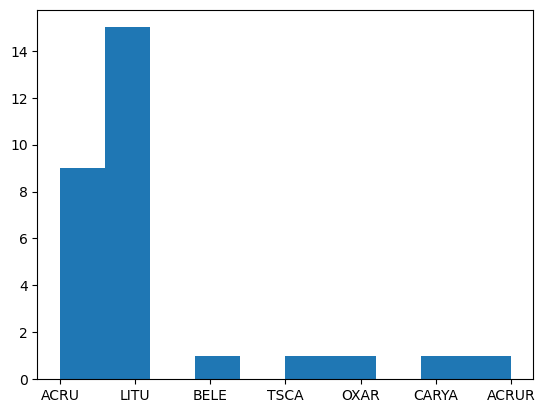

In [165]:
plt.hist(meta['phenogeo'].apply(lambda x: (x['taxonID_y'].values[0])))


In [166]:
meta['phenogeo'].apply(lambda x: (x['uid'].values[0])).nunique()

29

In [167]:
print(meta['phenogeo'][best_index][['utmZone', 'adjEasting', 'adjNorthing']])

print(meta['centoid'][best_index])
print(meta['distance'][best_index])

     utmZone     adjEasting     adjNorthing
3595     17N  275345.516997  3951208.193828
POINT (275648.60000000003 3951597.9499999997)
0.23705548764218623


In [168]:
rgb_points = meta['rgb'][best_index][['xmin', 'ymin', 'xmax', 'ymax']].values[0]
hsi_points = meta['hsi'][best_index][['xmin', 'ymin', 'xmax', 'ymax']].values[0]

In [172]:
print(rgb_points)
print(hsi_points)

[1500.0 328.0 1583.0 420.0]
[150 32 159 42]


In [170]:
import matplotlib.pyplot as plt

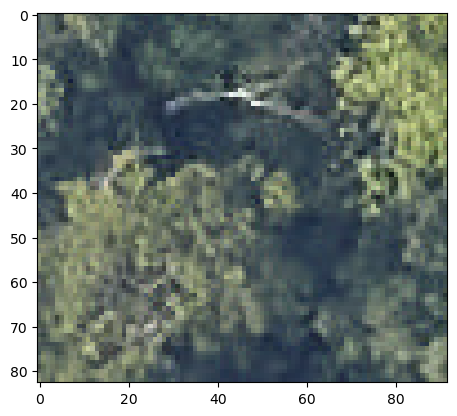

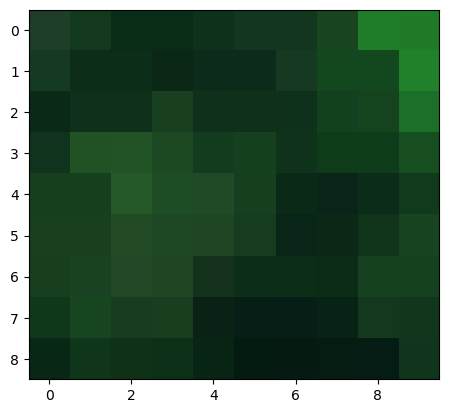

In [171]:
rgb_img = img.data.copy().transpose(1,2,0)
plt.imshow(rgb_img[int(rgb_points[0]):int(rgb_points[2]), int(rgb_points[1]):int(rgb_points[3]), :])
plt.show()
hsi_img = reflectance_data.copy()[:,:,[58, 34, 19]]
hsi_img = hsi_img / hsi_img.max()
plt.imshow(hsi_img[int(hsi_points[0]):int(hsi_points[2]), int(hsi_points[1]):int(hsi_points[3]), :]) 
plt.show()

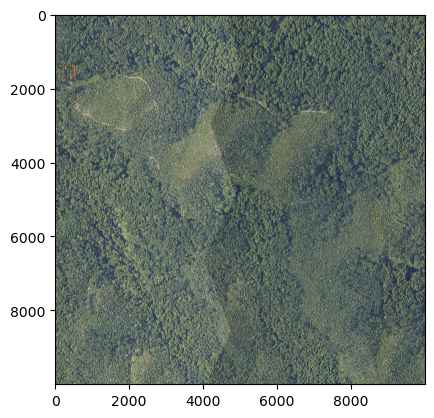

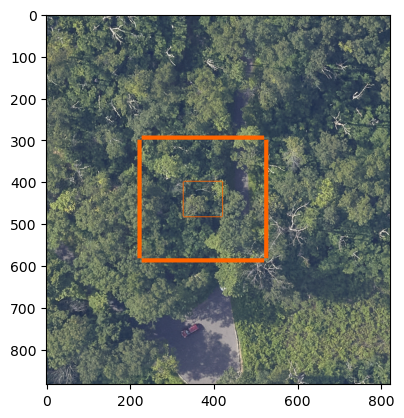

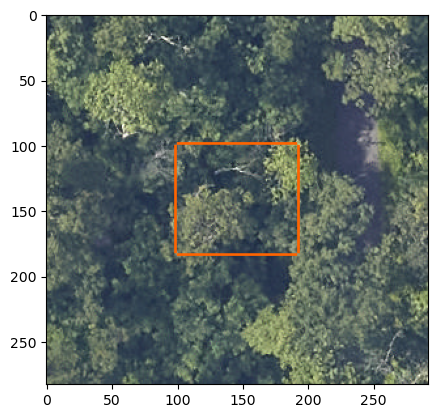

In [175]:
rgb_img = img.data.copy().transpose(1,2,0)

rgb_points = [int(x) for x in rgb_points]
larger_bounds = [int(rgb_points[0]-100), int(rgb_points[1]-100), int(rgb_points[2]+100), int(rgb_points[3]+100)]

rgb_img[rgb_points[0]-2:rgb_points[0], rgb_points[1]:rgb_points[3], :] = [255, 100, 0]
rgb_img[rgb_points[2]:rgb_points[2]+2, rgb_points[1]:rgb_points[3], :] = [255, 100, 0]
rgb_img[rgb_points[0]:rgb_points[2], rgb_points[1]-2:rgb_points[1], :] = [255, 100, 0]
rgb_img[rgb_points[0]:rgb_points[2], rgb_points[3]:rgb_points[3]+2, :] = [255, 100, 0]

rgb_img[larger_bounds[0]-10:larger_bounds[0], larger_bounds[1]:larger_bounds[3], :] = [255, 100, 0]
rgb_img[larger_bounds[2]:larger_bounds[2]+10, larger_bounds[1]:larger_bounds[3], :] = [255, 100, 0]
rgb_img[larger_bounds[0]:larger_bounds[2], larger_bounds[1]-10:larger_bounds[1], :] = [255, 100, 0]
rgb_img[larger_bounds[0]:larger_bounds[2], larger_bounds[3]:larger_bounds[3]+10, :] = [255, 100, 0]


plt.imshow(rgb_img)
plt.show()

plt.imshow(rgb_img[max(0,int(rgb_points[0]-400)):int(rgb_points[2]+400), max(0,int(rgb_points[1]-400)):int(rgb_points[3]+400), :])
plt.show()

plt.imshow(rgb_img[int(rgb_points[0]-100):int(rgb_points[2]+100), int(rgb_points[1]-100):int(rgb_points[3]+100), :])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


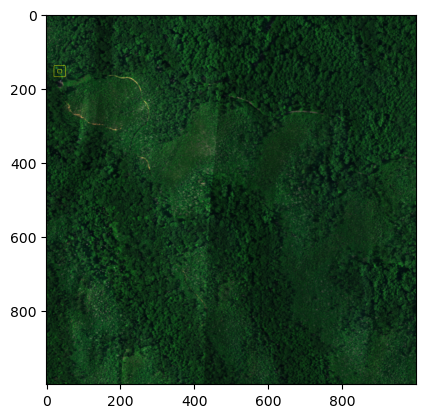

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


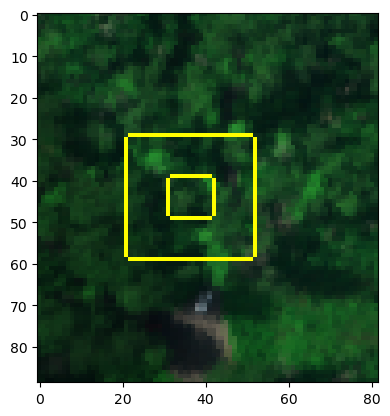

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


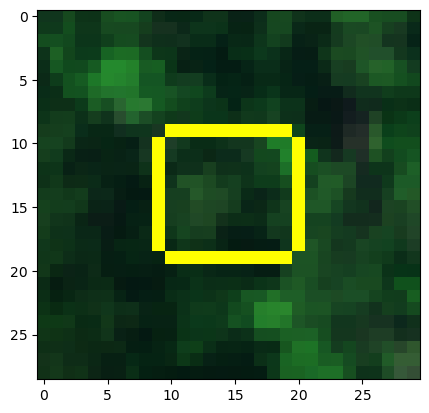

In [176]:
hsi_img = reflectance_data.copy()[:,:,[58, 34, 19]]
hsi_img = hsi_img / hsi_img.max()
hsi_points = [int(x) for x in hsi_points]
larger_bounds = [int(hsi_points[0])-10, int(hsi_points[1])-10, int(hsi_points[2])+10, int(hsi_points[3])+10]


hsi_img[hsi_points[0]-1:hsi_points[0], hsi_points[1]:hsi_points[3], :] = [255, 100, 0]
hsi_img[hsi_points[2]:hsi_points[2]+1, hsi_points[1]:hsi_points[3], :] = [255, 100, 0]
hsi_img[hsi_points[0]:hsi_points[2], hsi_points[1]-1:hsi_points[1], :] = [255, 100, 0]
hsi_img[hsi_points[0]:hsi_points[2], hsi_points[3]:hsi_points[3]+1, :] = [255, 100, 0]

hsi_img[larger_bounds[0]-1:larger_bounds[0], larger_bounds[1]:larger_bounds[3], :] = [255, 100, 0]
hsi_img[larger_bounds[2]:larger_bounds[2]+1, larger_bounds[1]:larger_bounds[3], :] = [255, 100, 0]
hsi_img[larger_bounds[0]:larger_bounds[2], larger_bounds[1]-1:larger_bounds[1], :] = [255, 100, 0]
hsi_img[larger_bounds[0]:larger_bounds[2], larger_bounds[3]:larger_bounds[3]+1, :] = [255, 100, 0]




plt.imshow(hsi_img)
plt.show()

plt.imshow(hsi_img[max(0,int(hsi_points[0]-40)):int(hsi_points[2]+40), max(0,int(hsi_points[1]-40)):int(hsi_points[3]+40), :])
plt.show()

plt.imshow(hsi_img[int(hsi_points[0]-10):int(hsi_points[2]+10), int(hsi_points[1]-10):int(hsi_points[3]+10), :])
plt.show()


In [179]:
meta['rgb'][best_index]

xmin   ymin    xmax   ymax label    score  \
0  1500.0  328.0  1583.0  420.0  Tree  0.87712   

                             image_path  \
0  2021_GRSM_5_275000_3951000_image.tif   

                                                                                                                   geometry  
0  POLYGON ((275158.35 3951967.15, 275158.35 3951957.95, 275150.05 3951957.95, 275150.05 3951967.15, 275158.35 3951967.15))

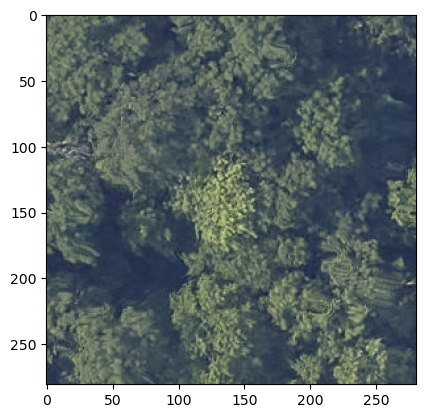

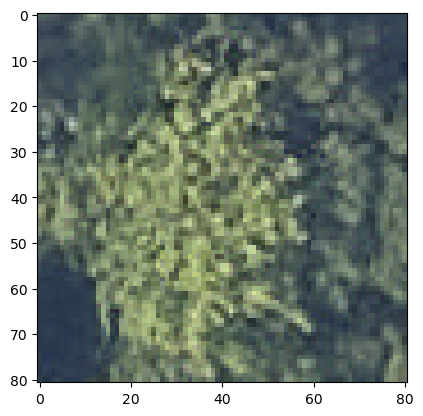

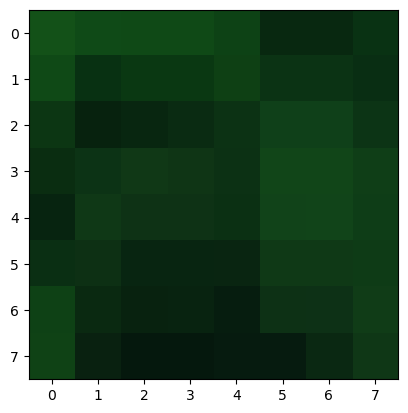

KeyError: 'species'

In [83]:
# rgb = 58, 34, 19
import matplotlib.pyplot as plt
for value in sorted_dict.values():
    row = value[1]
    rgb_points = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
    hsi_points = [round(point/10) for point in rgb_points]

    rgb_img = img.data.copy().transpose(1,2,0)
    plt.imshow(rgb_img[int(rgb_points[0]):int(rgb_points[2]), int(rgb_points[1]):int(rgb_points[3]), :])
    plt.show()
    # select only rgb channels (58, 34, 19)
    hsi_img = reflectance_data.copy()[:,:,[58, 34, 19]]
    hsi_img = hsi_img / hsi_img.max()
    plt.imshow(hsi_img[int(hsi_points[0]):int(hsi_points[2]), int(hsi_points[1]):int(hsi_points[3]), :]) 
    plt.show()
    # print(rgb_points)
    # print(hsi_points)
    print(value[0]['species'])
    
    break

In [95]:
for values in list(sorted_dict.values())[:100]:
    row = values[0]['taxonID_y']
    print(row)
    

TSCA
LITU
ACRU
LITU
LITU
ACRU
OXAR
LITU
ACRU
ACRU
LITU
LITU
LITU
ACRU
LITU
ACRU
ACRU
ACRU
BELE
ACRU
LITU
ACRU
LITU
LITU
ACRU
LITU
LITU
LITU
LITU
ACRU
ACRU
LITU
TSCA
ACRU
LITU
TSCA
LITU
BELE
LITU
LITU
ACRU
ACRU
ACRU
LITU
BELE
LITU
TSCA
LITU
LITU
ACRU
ACRU
ACRU
LITU
LITU
ACRU
TSCA
ACRU
LITU
LITU
LITU
LITU
BELE
ACRU
LITU
LITU
BELE
ACRU
LITU
BELE
LITU
ACRU
ACRU
LITU
LITU
LITU
TSCA
ACRU
LITU
LITU
ACRU
ACRU
ACRU
BELE
BELE
ACRU
ACRU
ACRU
ACRU
LITU
LITU
LITU
ACRU
TSCA
ACRU
ACRU
ACRU
LITU
LITU
ACRU
ACRU


In [88]:
row

uid_x                                                             NaN
namedLocation_x                                                   NaN
domainID_x                                                        NaN
siteID_x                                                          NaN
plotID_x                                                          NaN
decimalLatitude_x                                                 NaN
decimalLongitude_x                                                NaN
geodeticDatum_x                                                   NaN
coordinateUncertainty_x                                           NaN
elevation_x                                                       NaN
elevationUncertainty_x                                            NaN
subtypeSpecification_x                                            NaN
transectMeter_x                                                   NaN
directionFromTransect_x                                           NaN
ninetyDegreeDistance

MemoryError: Unable to allocate 79.3 GiB for an array with shape (42600000000,) and data type int16

In [69]:
df['utmZone'].unique()

array(['17N', '18N', '16N'], dtype=object)

In [263]:
from shapely.geometry import box
from pyproj import Transformer
import numpy as np

# Define the CRS for the pixel coordinates (assuming it's rgb_crs)
pixel_crs = rgb_crs

# Create a transformer object for pixel to UTM conversion
transformer_pix_to_utm = Transformer.from_crs(pixel_crs, 'EPSG:32617', always_xy=True, only_best=True)
# Create a transformer object for UTM to latlon conversion
transformer_utm_to_latlon = Transformer.from_crs('EPSG:32617', 'EPSG:4326', always_xy=True, only_best=True)

# Iterate over each bounding box in hsi_boxes DataFrame
for index, row in hsi_boxes.iterrows():
    # Get the bounding box coordinates in pixel coordinates
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    
    # Create a shapely box object
    bounding_box = box(xmin, ymin, xmax, ymax)
    
    # Find the centroid of the bounding box
    centroid = bounding_box.centroid
    
    # Convert the centroid coordinates to UTM
    pix_utm_x, pix_utm_y = transformer_pix_to_utm.transform(centroid.x, centroid.y)
    
    print(pix_utm_x, pix_utm_y)


8238.0 4098.0
6576.5 7954.5
5715.0 8315.5
8559.0 2692.5
9799.5 4202.5
8166.5 5968.0
5747.0 4208.0
9330.0 6791.5
6925.5 3851.0
6481.5 6412.5
9833.0 5118.5
4612.5 4213.0
5092.5 6429.5
7579.0 3080.5
6224.5 8542.0
9805.0 5690.5
8096.0 233.5
4580.0 4336.5
8699.0 3853.0
6185.0 5670.5
7524.0 4319.0
6497.5 6967.5
9935.0 7087.5
5304.0 5971.0
8761.0 7211.0
4761.0 2038.0
9231.5 6839.5
7201.5 9783.0
6804.5 3518.0
7564.0 3763.5
6459.0 1969.5
4728.0 9068.0
9417.0 6338.0
9193.0 6578.5
5714.5 455.5
6393.5 6202.5
7196.0 6201.0
9404.0 1148.5
6294.5 7219.5
5694.5 4330.5
7112.0 9895.5
4848.0 2692.0
7604.0 5995.5
9066.0 4540.0
3693.0 5675.0
5048.5 7498.5
6614.0 9856.0
5162.5 8317.0
4549.0 9558.0
9178.5 3437.0
5966.0 3831.5
6911.0 6537.5
8198.5 5668.5
5287.0 77.0
7841.5 2176.5
6045.0 3177.0
8668.5 1212.5
5986.5 8334.5
7026.5 4239.0
5407.0 8713.0
9936.0 5080.5
8272.0 2013.5
5405.0 5453.0
8974.0 4941.5
5597.0 7257.5
7658.0 4187.0
7290.5 5670.5
9453.5 5668.0
9292.0 1742.5
7867.5 4463.5
7252.0 6058.0
6047.0 961

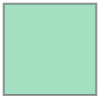

In [284]:
img.gdf['geometry'][0]

In [285]:
from shapely.geometry import Polygon
from pyproj import Transformer
import numpy as np

# Create a transformer object for pixel to UTM conversion
transformer_pix_to_utm = Transformer.from_crs(rgb_crs, 'EPSG:32617', always_xy=True, only_best=True)

# Iterate over each row in gdf
for index, row in img.gdf.iterrows():
    # Get the polygon geometry
    polygon = row['geometry']
    
    # Get the centroid of the polygon
    centroid = polygon.centroid
    
    # Convert the centroid coordinates to UTM
    pix_utm_x, pix_utm_y = transformer_pix_to_utm.transform(centroid.x, centroid.y)
    
    print(pix_utm_x, pix_utm_y)




267823.8499999999 3942590.1500000004
267657.70000000007 3942204.5
267571.55 3942168.4
267855.95 3942730.7000000007
267980.0 3942579.7
267816.7 3942403.1500000004
267574.75 3942579.1499999994
267933.05 3942320.8
267692.6 3942614.8500000006
267648.19999999995 3942358.700000001
267983.35000000003 3942488.0999999996
267461.30000000005 3942578.6500000004
267509.3 3942356.9999999995
267757.95 3942691.9
267622.50000000006 3942145.75
267980.54999999993 3942430.9000000004
267809.6500000001 3942976.6000000006
267458.05 3942566.2999999993
267869.94999999995 3942614.6500000004
267618.55 3942432.9
267752.45 3942568.05
267649.80000000005 3942303.2
267993.54999999993 3942291.2000000007
267530.45 3942402.8499999996
267876.14999999997 3942278.85
267476.15 3942796.15
267923.19999999995 3942316.0
267720.20000000007 3942021.6499999994
267680.5 3942648.15
267756.45 3942623.6
267645.95 3942803.0000000005
267472.85 3942093.1499999994
267941.75 3942366.15
267919.35 3942342.0999999996
267571.5 3942954.4
267639

In [220]:
img.image.shape

(10000, 10000)

In [230]:
df.head()

uid_x         namedLocation_x domainID_x  \
0  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   
1  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   
2  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   
3  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   
4  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   

  siteID_x  plotID_x  decimalLatitude_x  decimalLongitude_x geodeticDatum_x  \
0     SCBI  SCBI_060          38.890173          -78.139772           WGS84   
1     SCBI  SCBI_060          38.890173          -78.139772           WGS84   
2     SCBI  SCBI_060          38.890173          -78.139772           WGS84   
3     SCBI  SCBI_060          38.890173          -78.139772           WGS84   
4     SCBI  SCBI_060          38.890173          -78.139772           WGS84   

   coordinateUncertainty_x  elevation_x  elevationUncertainty_x  \
0                      NaN        359.8                     NaN   
1                      NaN        359.8                     NaN   
2                      NaN        359.8                     NaN   
3                      NaN        359.8                     NaN   
4                      NaN        359.8                     NaN   

  subtypeSpecification_x  transectMeter_x directionFromTransect_x  \
0                primary            335.0                    Left   
1                primary            335.0                    Left   
2                primary            335.0                    Left   
3                primary            335.0                    Left   
4                primary            335.0                    Left   

   ninetyDegreeDistance_x  sampleLatitude_x  sampleLongitude_x  \
0                     1.0               NaN                NaN   
1                     1.0               NaN                NaN   
2                     1.0               NaN                NaN   
3                     1.0               NaN                NaN   
4                     1.0               NaN                NaN   

   sampleGeodeticDatum_x  sampleCoordinateUncertainty_x  sampleElevation_x  \
0                    NaN                            NaN                NaN   
1                    NaN                            NaN                NaN   
2                    NaN                            NaN                NaN   
3                    NaN                            NaN                NaN   
4                    NaN                            NaN                NaN   

   sampleElevationUncertainty_x      date_x editedDate_x  \
0                           NaN  2014-10-10   2020-07-14   
1                           NaN  2014-10-10   2020-07-14   
2                           NaN  2014-10-10   2020-07-14   
3                           NaN  2014-10-10   2020-07-14   
4                           NaN  2014-10-10   2020-07-14   

              individualID taxonID_x                        scientificName_x  \
0  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   
1  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   
2  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   
3  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   
4  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   

   identificationQualifier_x taxonRank_x nativeStatusCode_x growthForm_x  \
0                        NaN     species                  I    Graminoid   
1                        NaN     species                  I    Graminoid   
2                        NaN     species                  I    Graminoid   
3                        NaN     species                  I    Graminoid   
4                        NaN     species                  I    Graminoid   

   vstTag_x samplingProtocolVersion_x                measuredBy_x  \
0       NaN         NEON.DOC.014040vM 